# Make plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50

In [2]:
url_1 = 'https://www.fueleconomy.gov/feg/epadata/vehicles.csv'
url_2 = 'https://www.fueleconomy.gov/feg/epadata/emissions.csv'

vehicle = pd.read_csv(url_1, low_memory=False)
emissions = pd.read_csv(url_2)

In [3]:
cols_needed = ['make', 'model', 'VClass', 'score', 'scoreAlt', 'smartwayScore',
               'barrels08', 'barrelsA08', 'charge240', 'city08', 'cityA08', 'co2', 'co2A', 'comb08', 'combA08', 'startStop',
               'cylinders', 'drive', 'feScore', 'fuelCost08', 'fuelCostA08', 'fuelType', 'fuelType1', 'highway08', 'highwayA08',
               'highwayE', 'hlv', 'hpv', 'lv2', 'lv4', 'pv2', 'pv4', 'trany', 'year', 'tCharger', 'sCharger'
              ]

df = (vehicle
 .merge(emissions, how='inner', on='id')
 [cols_needed]
)

In [5]:
df.head(3)

,make,model,VClass,score,scoreAlt,smartwayScore,barrels08,barrelsA08,charge240,city08,cityA08,co2,co2A,comb08,combA08,startStop,cylinders,drive,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,highway08,highwayA08,highwayE,hlv,hpv,lv2,lv4,pv2,pv4,trany,year,tCharger,sCharger
0,Acura,NSX,Two Seaters,1.0,-1.0,-1,16.528333,0.0,0.0,16,0,-1,-1,18,0,NaN,6.0,Rear-Wheel Drive,-1,3700,0,Premium,Premium Gasoline,22,0,0.0,0,0,0,0,0,0,Automatic (S4),2004,NaN,NaN
1,Acura,NSX,Two Seaters,1.0,-1.0,-1,16.528333,0.0,0.0,16,0,-1,-1,18,0,NaN,6.0,Rear-Wheel Drive,-1,3700,0,Premium,Premium Gasoline,22,0,0.0,0,0,0,0,0,0,Automatic (S4),2004,NaN,NaN
2,Acura,NSX,Two Seaters,1.0,-1.0,-1,16.528333,0.0,0.0,16,0,-1,-1,18,0,NaN,6.0,Rear-Wheel Drive,-1,3700,0,Premium,Premium Gasoline,22,0,0.0,0,0,0,0,0,0,Manual 6-spd,2004,NaN,NaN


In [9]:
def assign_car_type(df):
    Pickup = ['Standard Pickup Trucks 2WD', 'Standard Pickup Trucks 4WD', 'Small Pickup Trucks 2WD', 'Small Pickup Trucks 4WD']
    SUV = ['Sport Utility Vehicle - 2WD', 'Sport Utility Vehicle - 4WD', 'Small Sport Utility Vehicle 4WD', 'Standard Sport Utility Vehicle 2WD', 'Standard Sport Utility Vehicle 4WD', 'Small Sport Utility Vehicle 2WD']
    SPV = ['Special Purpose Vehicle 2WD', 'Special Purpose Vehicle 4WD']
    Van = ['Vans, Cargo Type', 'Vans, Passenger Type', 'Minivan - 2WD', 'Minivan - 4WD']
    Wagon = ['Small Station Wagons', 'Midsize Station Wagons']

    car_types = {'Pickup': Pickup, 'SUV': SUV, 'SPV': SPV, 'Van': Van, 'Wagon': Wagon}

    df['CarType'] = [next((car_type for car_type, car_list in car_types.items() if class_val in car_list), 'Other') for class_val in df['VClass']]

    return df

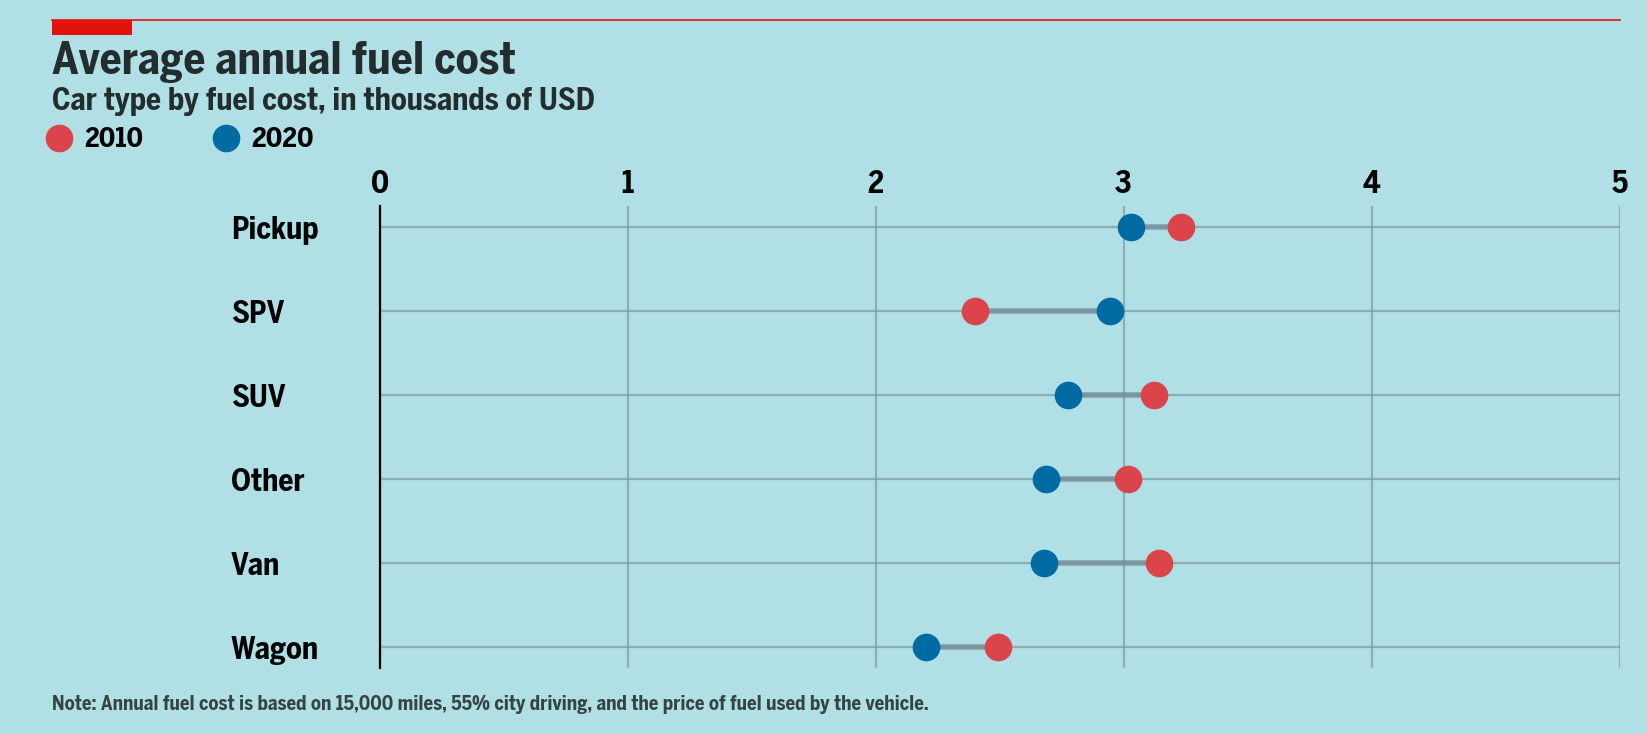

In [10]:
from matplotlib import font_manager

for font in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    font_manager.fontManager.addfont(font)

plt.rcParams['font.family'] = 'BentonSans Cond Bold'

car_type_fuel = (df
 .pipe(assign_car_type)
 .assign(fuelCost08_in_K=lambda df_: df_.fuelCost08/1000)
 .loc[df.year.isin([2010, 2020])]
 .groupby(['CarType', 'year'])
 .agg({'fuelCost08_in_K': 'mean'})
 .unstack()
 .droplevel(level=0, axis=1)
 .sort_values(2020)
)

fig, ax = plt.subplots(figsize=(8,3), dpi=200, facecolor='#B0E0E6')
ax.set_facecolor('#B0E0E6')
ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)
ax.spines[['top','right','bottom']].set_visible(False)

ax.hlines(y=car_type_fuel.index, xmin=car_type_fuel[2010], xmax=car_type_fuel[2020],
          color='#758D99', zorder=2, linewidth=2, label='_nolegend_', alpha=.8)
# Plot bubbles next
ax.scatter(car_type_fuel[2010], car_type_fuel.index, label='2010', s=80, color='#DB444B', zorder=3)
ax.scatter(car_type_fuel[2020], car_type_fuel.index, label='2020', s=80, color='#006BA2', zorder=3)

# Set xlim
ax.set_xlim(0, 5)

# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1)             # Lower tick labels a bit

# Reformat y-axis tick labels
ax.set_yticks(car_type_fuel.index)
ax.set_yticklabels(car_type_fuel.index,       # Set labels again
                   ha = 'left')              # Set horizontal alignment to left
ax.yaxis.set_tick_params(pad=50,            # Pad tick labels so they don't go over y-axis
                         labelsize=11,       # Set label size
                         bottom=False)       # Set no ticks on bottom/left

# Set Legend
ax.legend(['2010', '2020'], loc=(-.29,1.09), ncol=2, frameon=False, handletextpad=-.1, handleheight=1)

# Add in line and tag
ax.plot([-0.08, .9],                 # Set width of line
        [1.19, 1.19],                # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
ax.add_patch(plt.Rectangle((-0.08,1.19),               # Set location of rectangle by lower left corder
                           0.05,                       # Width of rectangle
                           -0.025,                      # Height of rectangle. Negative so it goes down.
                           facecolor='#E3120B', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

# Add in title and subtitle
ax.text(x=-0.08, y=1.1, s="Average annual fuel cost", transform=fig.transFigure, ha='left', fontsize=16, weight='bold', alpha=.8)
ax.text(x=-0.08, y=1.04, s="Car type by fuel cost, in thousands of USD",
        transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

# Set source text
ax.text(x=-0.08, y=0.04, s="""Note: Annual fuel cost is based on 15,000 miles, 55% city driving, and the price of fuel used by the vehicle.""",
        transform=fig.transFigure, ha='left', fontsize=7, alpha=.7);


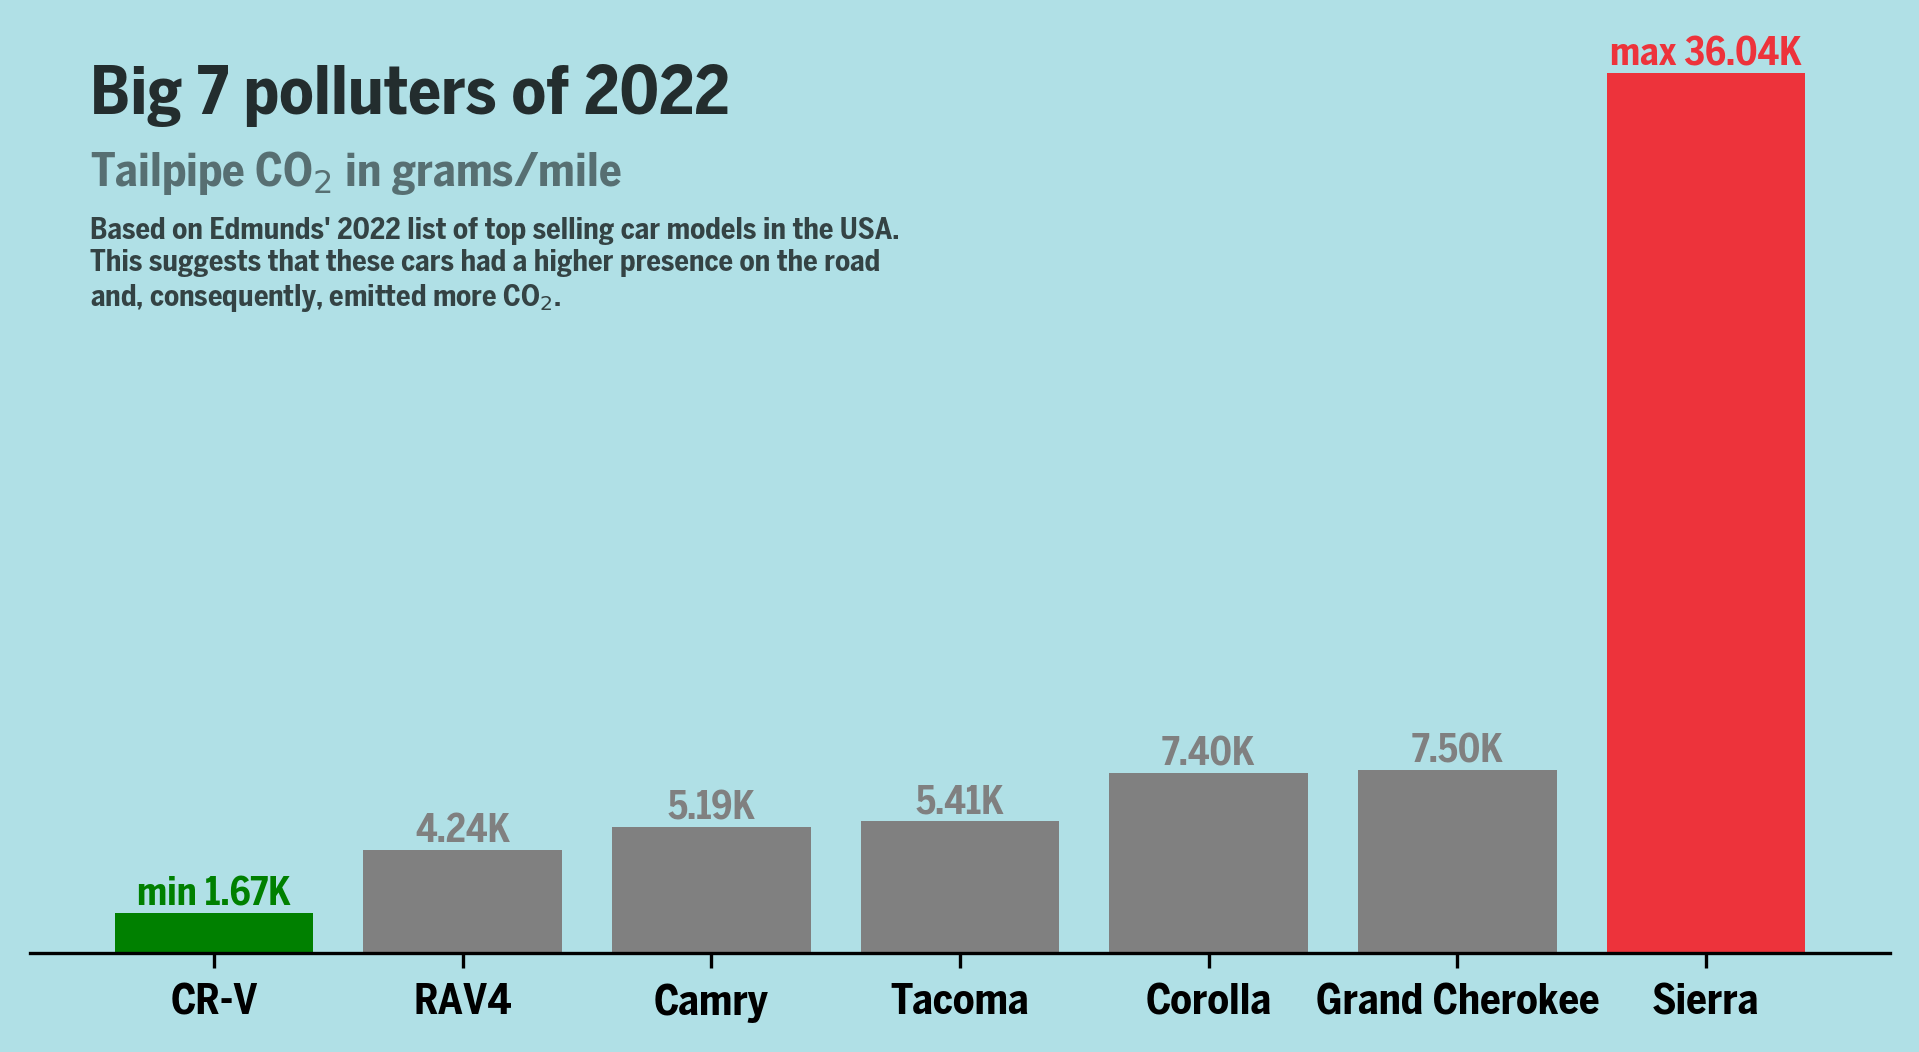

In [6]:
mapping = {'F-':'F-150', 'Model Y':'Model Y', 'RAV4':'RAV4', 'Ram ':'Ram ', 'Camry':'Camry',
           'CR-V':'CR-V', 'Sierra':'Sierra', 'Tacoma':'Tacoma', 'Corolla':'Corolla', 'Grand Cherokee':'Grand Cherokee'}

data = (df
 .loc[((df.make.str.contains('Ford')) & (df.model.str.contains('F-'))) |\
      (df.model.str.contains('Model Y')) | (df.model.str.contains('RAV4')) |\
      (df.model.str.contains('Ram ')) | (df.model.str.contains('Camry')) |\
      (df.model.str.contains('CR-V')) | (df.model.str.contains('Sierra')) |\
      (df.model.str.contains('Tacoma')) | (df.model.str.contains('Corolla')) |\
      (df.model.str.contains('Grand Cherokee'))]
 .assign(big_ten=lambda df_: df_.model.str.extract(f"({'|'.join(mapping.keys())})")[0].map(mapping))
 .assign(co2_in_K=lambda df_: df_.co2/1000)
 .loc[df.year == 2022]
 .groupby('big_ten')
 .agg({'co2_in_K': 'sum'})
 .nlargest(7, 'co2_in_K')
 .sort_values('co2_in_K')
)

BAR_COLOR = '#808080'  # light 3
COLOR_MIN = '#008000'  # red 2
COLOR_MAX = '#ed333b'  # green 2

# Determine the colors for each bar
colors = [COLOR_MAX if x == max(data['co2_in_K']) else COLOR_MIN if x == min(data['co2_in_K']) else BAR_COLOR for x in data['co2_in_K']]

fig, ax = plt.subplots(figsize=(8,4), dpi=300, facecolor='#B0E0E6')
ax.set_facecolor('#B0E0E6')
ax.bar(x=data.index, height=data['co2_in_K'], color=colors)
# plt.suptitle('Big 7 polluters of 2022', fontsize=16, x=0.3, y=.85)
ax.text(0.15, .81, s='Big 7 polluters of 2022', transform=fig.transFigure, ha='left', fontsize=16, weight='bold', alpha=.8)
ax.text(0.15, .75, s='Tailpipe CO$_2$ in grams/mile', transform=fig.transFigure, ha='left', fontsize=11, weight='bold', alpha=.5)
ax.text(0.15, .65, s="Based on Edmunds' 2022 list of top selling car models in the USA.\nThis suggests that these cars had a higher presence on the road\nand, consequently, emitted more CO$_2$.", transform=fig.transFigure, ha='left', fontsize=7, alpha=.7)
ax.spines[['top', 'left', 'right']].set_visible(False)
ax.tick_params(axis='y', which='major', left=False, labelleft=False)

# Add bar data labels
for x_val, y_val in enumerate(data['co2_in_K']):
    txt = f'max {y_val:.2f}K' if y_val == max(data['co2_in_K']) else f'min {y_val:.2f}K' if y_val == min(data['co2_in_K']) else f'{y_val:.2f}K'
    col = COLOR_MAX if y_val == max(data['co2_in_K']) else COLOR_MIN if y_val == min(data['co2_in_K']) else BAR_COLOR
    ax.text(x_val, y_val, txt, ha='center', va='bottom', fontsize=9, color=col)

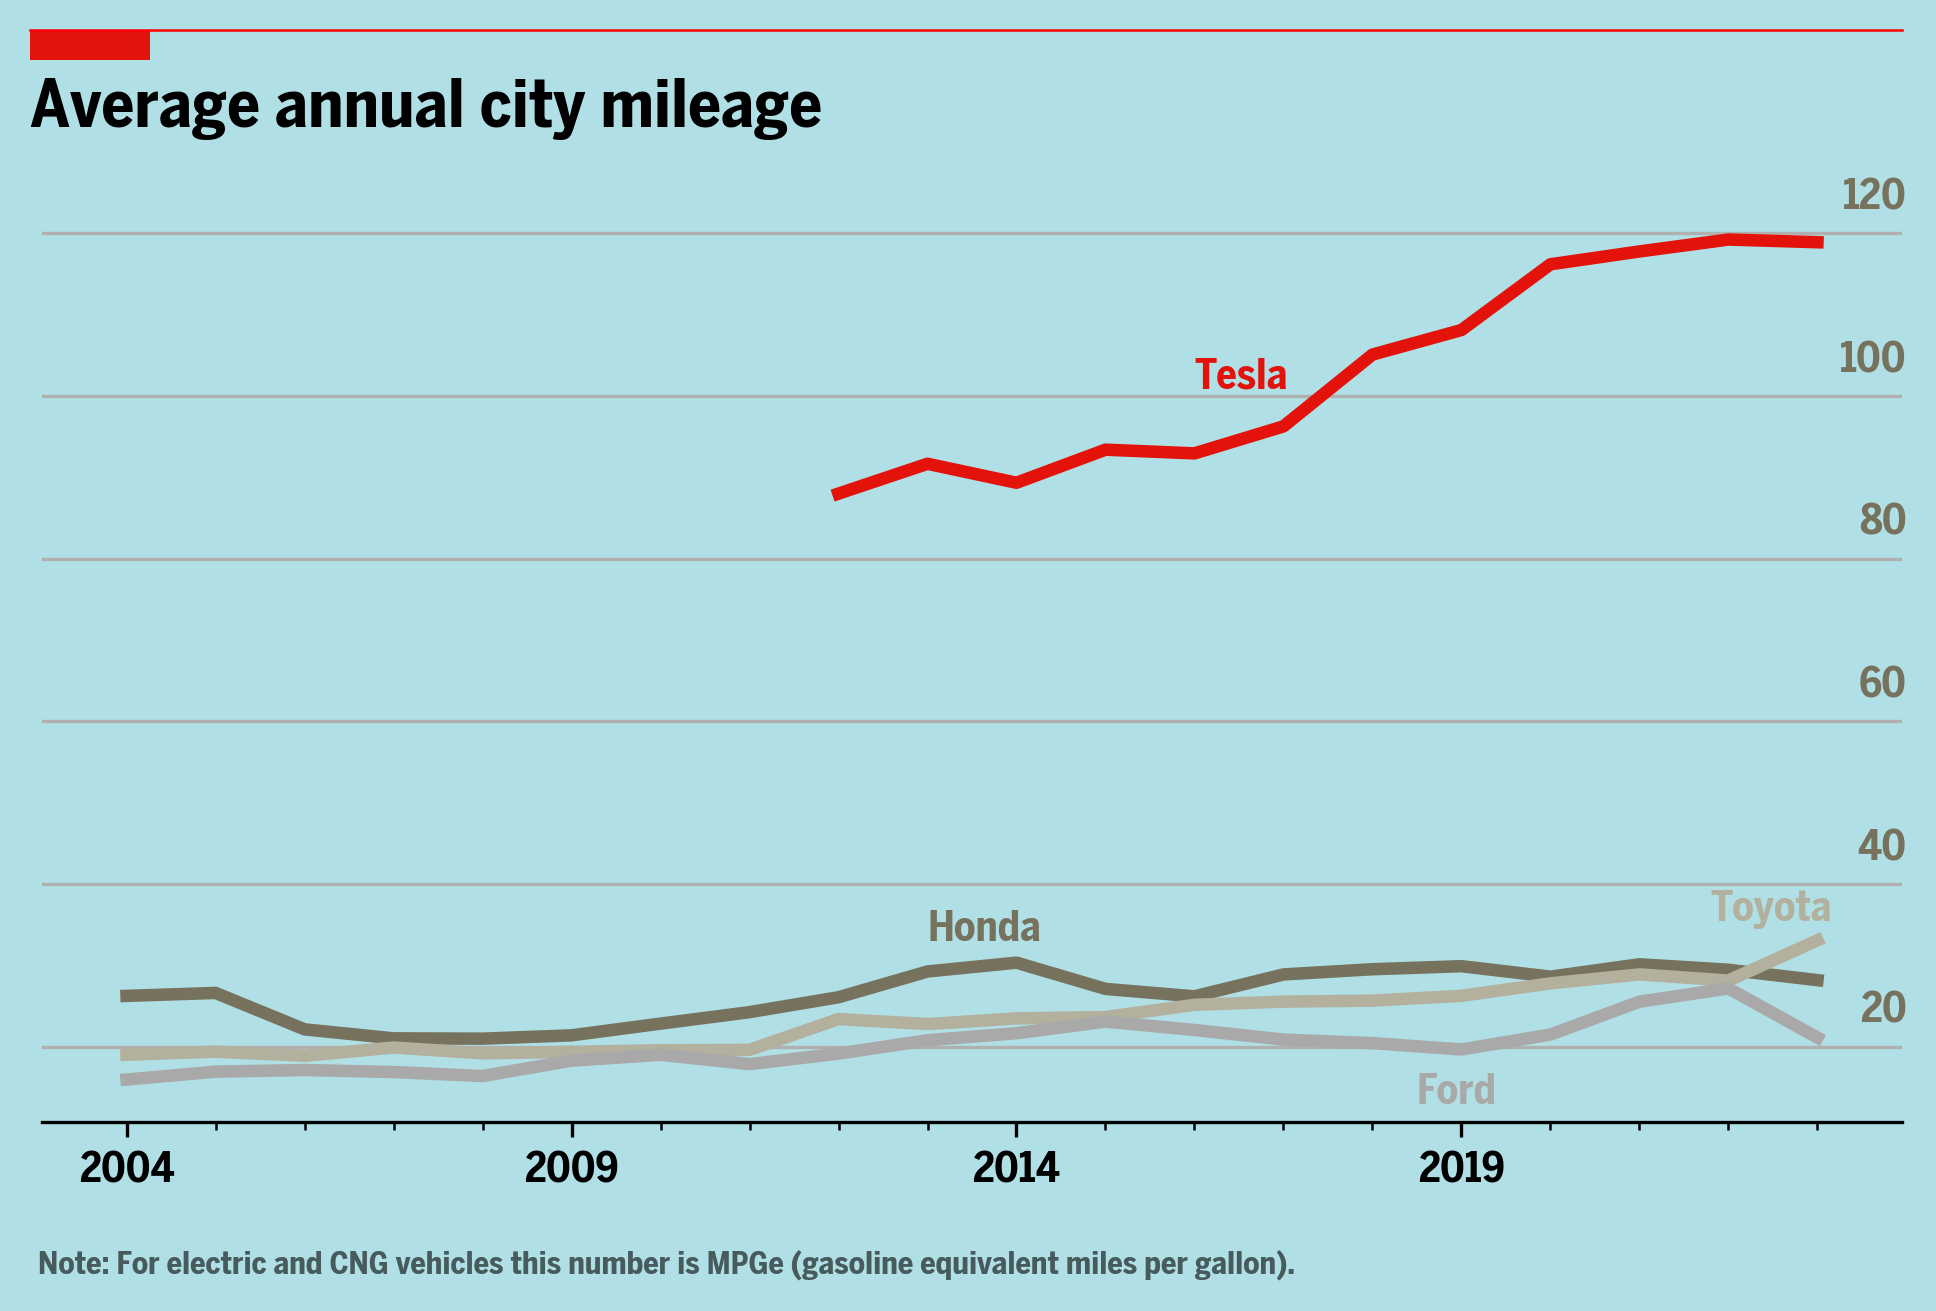

In [15]:
makes = ['Tesla', 'Honda', 'Toyota', 'Ford']
COLORS = ['#E3120B', '#76725E', '#B3B09E', '#A9A9A9']
fig, ax = plt.subplots(figsize=(8,4), dpi=300, facecolor='#B0E0E6')
dd = (df
#  .query('make.isin(@makes)')
 .loc[df.make.isin(makes)]
 .groupby(['year', 'make'])
 .city08
 .mean()
 .unstack()
 .loc[:, makes]
 .plot(color=COLORS, legend=False, linewidth=3, ax=ax)
)
plt.rcParams['font.family'] = 'BentonSans Cond Bold'
plt.grid(axis='y')
plt.suptitle('Average annual city mileage', ha='left', x=.12, fontsize=16)
ax.spines[['top', 'left', 'right']].set_visible(False)
ax.tick_params(left=False)  # hide ticks
ax.set_xlabel('')
ax.set_xticks(minor=True, ticks=range(2004,2024))
ax.set_facecolor('#B0E0E6')
# set positions and labels for major ticks
ax.set_xticks(ticks=range(2004,2029,5))
ax.set_xticklabels(['2004', '2009', '2014', '2019', '2024'])
ax.set_yticks(ticks=range(0,121,20))
ax.set_yticklabels([]) # hide left hand side.

# Add in line and tag
ax.plot([0.12,.9],                 # Set width of line
        [1.02, 1.02],                # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='r', 
        linewidth=.6)
ax.add_patch(plt.Rectangle((0.12,1.02),               # Set location of rectangle by lower left corder
                           0.05,                       # Width of rectangle
                           -0.025,                      # Height of rectangle. Negative so it goes down.
                           facecolor='#E3120B', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

for label in range(20,121,20): # my own vertically shifted y-labels.
    ax.text(2024, label+3, f'{label}', color=COLORS[-3], ha='right')
for label, pos, color in zip(makes, [(2016, 101), # label makes
                                     (2013, 33),
                                     (2021.8, 35.5),
                                     (2018.5, 13),
                                    ], COLORS):
    ax.text(*pos, label, color=color, ha='left')
    ax.text(2003, -8, 'Note: For electric and CNG vehicles this number is MPGe (gasoline equivalent miles per gallon).',
            ha='left', fontsize=7.5, alpha=.2)